## Imports and simulation setup

In [1]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
import scipy.io
from time import sleep, process_time
import sys
import scipy

sim.ResetKernel()

mins = 6.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')
sim.local_num_threads = 8 # NEST recommends 1 thread per core

# 'simulate': Run on NEST to generate results, this will save the results to .npy files
# 'load': Load a prior run without running the NEST simulator

simulate_or_load = 'simulate'

# 'spiral': Generate a spiral trajectory
# 'rat': Load one or more Sargolini datasets from file

spiral_or_rat = 'spiral'

[INFO] [2022.10.6 16:3:12 /home/conda/feedstock_root/build_artifacts/nest-simulator_1580129125463/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.10.6 16:3:12 /home/conda/feedstock_root/build_artifacts/nest-simulator_1580129125463/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.18.0
 Built: Jan 27 2020 12:49:15

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

simulation length: 6.0 mins = 360000 ms

Oct 06 16:03:13 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Oct 06 16:03:13 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Oct 06 16:03:13 Network::create_rngs_ [Info]: 
  

In [2]:
# Population cell counts

# N_ex: number of cells in the excitatory rings
# N_in: number of cells in the inhibitory rings
# N_cj: number of cells in the conjunctive rings
# rings: number of mono-axis rings ('directional rings')
# omni_rings: number of axis-invariant rings ('speed rings')
# window_size: how large a window of excitatory ring cells is each principle axis cell sensitive to?
# N_pa_cells_per_ring: how many PA cells exist for each ring (more = finer binning of excitatory ring activity)
# N_pyramidals: how many pyramidal cells are there?

N_ex = 120
N_in = N_ex
N_cj = N_ex

rings = 3
omni_rings = 0

window_size = 10

N_pa_cells_per_ring = N_ex // window_size

N_pyramidals = 100

tension = True

minimum_input = 1500

# Connection Gaussian weight parameters

# sigma: variance for excitatory ring -> inhibitory ring weight Gaussian
# in_sigma: variance for inhibitory ring -> excitatory ring weight Gaussian
# in_cj_sigma: variance for inhibitory ring -> conjunctive rings weight Gaussian
# mu: mean offset of Gaussians (when used)
# prune_smaller_than: weights below this threshold will become 0, effectively removing the connection

sigma = 0.1
in_sigma = 0.05
in_cj_sigma = 0.12
mu = 0.5
prune_smaller_than = 10

# Connection scalar weight parameters. These are signed as appropriate later on

# base_ex: excitatory ring -> inhibitory ring weight strength (+)
# base_in: inhibitory ring -> excitatory ring weight strength (-)
# base_cj: conjunctive rings -> excitatory rings weight strength (+)
# w_ex_cj: excitatory rings -> conjunctive rings weight strength (+)
# w_in_cj: inhibitory_rings -> conjunctive rings weight strength (-)
# w_ex_pa: excitatory_rings -> principle axis cells weight strength (+)
# w_pa_py: principle axis cells -> pyramidal cells weight strength (+)

base_ex = 5000
base_in = 1500
base_cj = 500
w_ex_cj = 440
w_in_cj = 1000 # Heading down
w_ex_pa = 1500#380 # 300
#w_pa_py = 200
w_pa_anti_py = 1#500
w_anti_py_py = 575#560
w_py_anti_py = 600

# Synaptic transmission delay (I believe this includes the synapse proper and action potential travel time)

delay = 0.1 

# Velocity scaling parameters

# I_vel: multiply incoming velocity by this amount to get the input current representing the vestibular signal
# velocity_threshold: Are very small values for velocity set to zero?
# miniumum_velocity: What is the minimum non-zero velocity? (only works if velocity_threshold is True)

I_vel = 1500

# Are conjuctive cells synapsed onto by excitatory layer or inhibitory layer.

# 'positive': scalar excitatory weight, conjunctive weights must be tuned to act as a coincidence detector for input velocity and bump activity
# 'negative': Gaussian inhibitory weight, suppresses incoming velocity input too far from the attractor bump
# 'both': inhibitory 'bowl' as per 'negative' and self-reinforcing excitatory connections

conjunctive_mode = 'negative'

# Intrinsic excitation of the excitatory ring, constant current in picoamps

intrinsic_excitation = 225.
intrinsic_excitation_pyramidals = 400.

# Initial (bump-forming) current injection parameters. This is a short spike of input to form the initial attractor state, to be adjusted by conjunctive input

# I_init: strength of input current in picoamps
# I_init_dur: how long this is applied for, in milliseconds
# I_init_pos: where is this applied, in ring index (1-120). NEST, for better or worse, has neuron IDs starting at 1 (whole network is GID 0)

I_init = 300.0
I_init_dur = 100.0
I_init_pos = N_ex//2

## Create neuron populations from the above parameters

In [3]:
# Lists to store each ring's population

#exc = []
#inh = []
#l = []
#r = []
pa_cells = []

for i in range(rings + omni_rings):

    #exc.append(sim.Create("iaf_psc_alpha",N_ex, params={"I_e": intrinsic_excitation})) # Excitatory layer, with intrinsic activity
    #inh.append(sim.Create("iaf_psc_alpha",N_in)) # Inhibitory layer

    #l.append(sim.Create("iaf_psc_alpha",N_cj)) # Conjunctive layer for left turn
    #r.append(sim.Create("iaf_psc_alpha",N_cj)) # Conjunctive layer for right turn
    
    pa_cells.append(sim.Create("iaf_psc_alpha",N_pa_cells_per_ring))
    
# The pyramidal cells associate across rings    

#pyramidal_cells = sim.Create("iaf_psc_alpha",N_pyramidals)
pyramidal_cells = sim.Create("iaf_psc_alpha",N_pyramidals, params={"I_e": intrinsic_excitation_pyramidals})

anti_pyramidal_cells = sim.Create("iaf_psc_alpha",N_pyramidals, params={"I_e": intrinsic_excitation_pyramidals})

## Define connection weight matrices

## Wire everything up

In [4]:
# Iterate through each and every combination of the ring neurons ([1,1,1], [1,1,2] ... [N, N, N]), assigning each trio to a pyramidal cell
# When all is said and done, this acts like a 3-digit, base-12 number, with each digit representing a ring

import pandas as pd

total_pa_cells = N_pa_cells_per_ring * rings

cell_indices = np.zeros(shape = (N_pyramidals)) # List of trios of cells, each the source of connections to a single pyramidal cell
target_cells = np.zeros(shape = (N_pyramidals))
source_pa_cells = np.zeros(shape = (rings, N_pyramidals))
source_pa_cell_indices = np.zeros(shape = (rings, N_pyramidals))

in_range = True

for r1 in (x for x in range(N_pa_cells_per_ring) if in_range is True): # Ring 1

    for r2 in (y for y in range(N_pa_cells_per_ring) if in_range is True): # Ring 2

        for r3 in (z for z in range(N_pa_cells_per_ring) if in_range is True): # Ring 3

            cell_index = (r1 * N_pa_cells_per_ring ** 2) + (r2 * N_pa_cells_per_ring) + r3 # Steps from 0 to max
            
            if cell_index != N_pyramidals:

                #target_cell = pyramidal_cells[cell_index]

                #sim.Connect([pa_cells[0][r1]], [target_cell],'all_to_all',syn_spec={'weight': w_pa_py, 'delay': delay})
                #sim.Connect([pa_cells[1][r2]], [target_cell],'all_to_all',syn_spec={'weight': w_pa_py, 'delay': delay})
                #sim.Connect([pa_cells[2][r3]], [target_cell],'all_to_all',syn_spec={'weight': w_pa_py, 'delay': delay})
                
                target_cell = anti_pyramidal_cells[cell_index]
                
                sim.Connect([pa_cells[0][r1]], [target_cell],'all_to_all',syn_spec={'weight': -w_pa_anti_py, 'delay': delay})
                sim.Connect([pa_cells[1][r2]], [target_cell],'all_to_all',syn_spec={'weight': -w_pa_anti_py, 'delay': delay})
                sim.Connect([pa_cells[2][r3]], [target_cell],'all_to_all',syn_spec={'weight': -w_pa_anti_py, 'delay': delay})

                # Gather up data for Pandas, to be used later in grid cell evalutation
                
                cell_indices[cell_index] = cell_index
                target_cells[cell_index] = target_cell
                source_pa_cells[0][cell_index] = pa_cells[0][r1]
                source_pa_cells[1][cell_index] = pa_cells[1][r2]
                source_pa_cells[2][cell_index] = pa_cells[2][r3]
                source_pa_cell_indices[0][cell_index] = r1
                source_pa_cell_indices[1][cell_index] = r2
                source_pa_cell_indices[2][cell_index] = r3
                
            else:
                
                in_range = False
                
pa_to_pyramidal_connections = pd.DataFrame({'Target Cell Index': cell_indices,
                                            'Target Pyramidal Cell': target_cells,
                                            'Ring 1 Index': source_pa_cell_indices[0],
                                            'Ring 2 Index': source_pa_cell_indices[1],
                                            'Ring 3 Index': source_pa_cell_indices[2],
                                            'Ring 1 PA Cell': source_pa_cells[0],
                                            'Ring 2 PA Cell': source_pa_cells[1],
                                            'Ring 3 PA Cell': source_pa_cells[2],})

print(pa_to_pyramidal_connections)

sim.Connect(pyramidal_cells, anti_pyramidal_cells,'one_to_one',syn_spec={'weight': w_py_anti_py, 'delay': delay})
sim.Connect(anti_pyramidal_cells, pyramidal_cells,'one_to_one',syn_spec={'weight': -w_anti_py_py, 'delay': delay})

    Target Cell Index  Target Pyramidal Cell  Ring 1 Index  Ring 2 Index  \
0                 0.0                  137.0           0.0           0.0   
1                 1.0                  138.0           0.0           0.0   
2                 2.0                  139.0           0.0           0.0   
3                 3.0                  140.0           0.0           0.0   
4                 4.0                  141.0           0.0           0.0   
..                ...                    ...           ...           ...   
95               95.0                  232.0           0.0           7.0   
96               96.0                  233.0           0.0           8.0   
97               97.0                  234.0           0.0           8.0   
98               98.0                  235.0           0.0           8.0   
99               99.0                  236.0           0.0           8.0   

    Ring 3 Index  Ring 1 PA Cell  Ring 2 PA Cell  Ring 3 PA Cell  
0            0.0    

## Record spike activity

In [5]:
# Single spike detectors, connected to all cells in the given population in a given ring
# 'params' dictionary describes which variables to log; gid: global neuron id, time is in milliseconds

#exc_spikes = []

#for i in range(rings + omni_rings):

#    exc_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
#    sim.Connect(exc[i],exc_spikes[i])

pa_spikes = []    

for i in range(rings):

    pa_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
    sim.Connect(pa_cells[i],pa_spikes[i])

pyramidal_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
sim.Connect(pyramidal_cells,pyramidal_spikes)

#inh_spikes = []

#for i in range(rings + omni_rings):

#    inh_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
#    sim.Connect(inh[i],inh_spikes[i])
    
#left_cj_spikes = []

#for i in range(rings + omni_rings):

#    left_cj_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
#    sim.Connect(l[i],left_cj_spikes[i])
    
#right_cj_spikes = []

#for i in range(rings + omni_rings):

#    right_cj_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
#    sim.Connect(r[i],right_cj_spikes[i])

## Record cell voltage

In [6]:
# Single spike detectors, connected to all cells in the given population in a given ring
# 'params' dictionary describes which variables to log; 'gid': global neuron id, 'time' is in milliseconds
# 'interval' is the frequency of logging, in milliseconds
# 'record_from' dictionary describes which neuron variables to log; 'V_m': membrane voltage, 
#                                                                   'weighted_spikes_ex': weighted sum of incoming excitatory spikes,
#                                                                   'weighted_spikes_in': weighted sum of incoming inhibitory spikes

#exc_voltage = []

#for i in range(rings + omni_rings):

#    exc_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
#    sim.Connect(exc_voltage[i],exc[i])

pa_voltage = []    

for i in range(rings):

    pa_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
    sim.Connect(pa_voltage[i], pa_cells[i])

pyramidal_voltage = sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']})
sim.Connect(pyramidal_voltage, pyramidal_cells)

#inh_voltage = []

#for i in range(rings + omni_rings):

#    inh_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
#    sim.Connect(inh_voltage[i], inh[i])
    
#left_cj_voltage = []

#for i in range(rings + omni_rings):

#    left_cj_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
#    sim.Connect(left_cj_voltage[i], l[i])
    
#right_cj_voltage = []

#for i in range(rings + omni_rings):

#    right_cj_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
#    sim.Connect(right_cj_voltage[i],r[i])

## Input to the network

### Position data

125.66370614359172
(17999, 4)
(17999,)
(17999,)


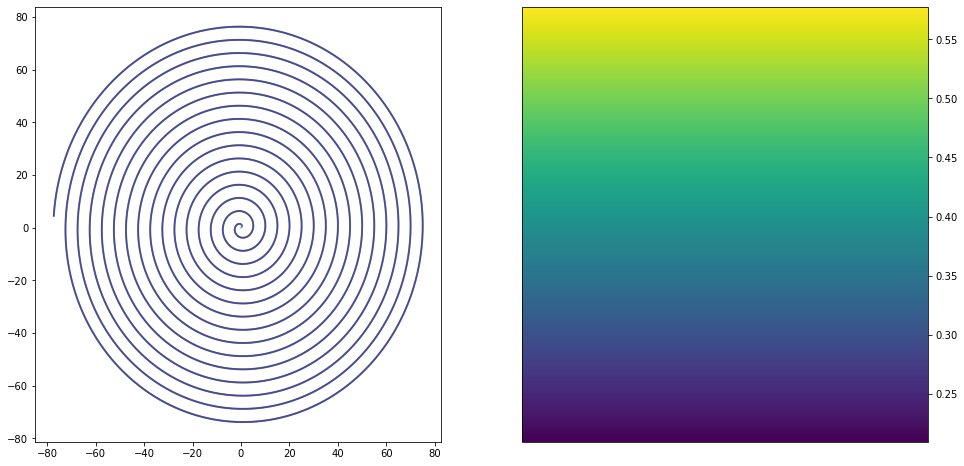

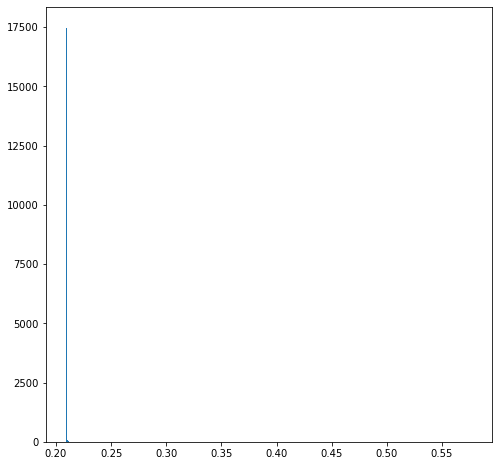

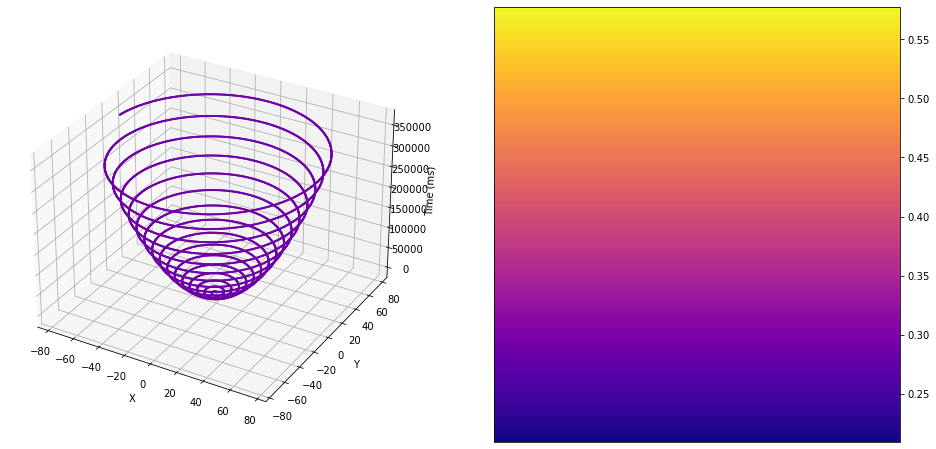

In [7]:
# Two options for getting input data for the network. In all cases, position data is loaded/generated, then velocity derived in later cells
# 'spiral': original spiral trajectory
# 'rat': load one of the Sargolini group's datasets, from real rat foraging task data

if spiral_or_rat == 'spiral':
    
    number_of_turns = 40
    numT = number_of_turns * 1000 * np.pi
    print(numT/1000)
    dt = 20
    t = np.arange(0,sim_len,dt)*1.
    time = [i * 1. for i in t if i < sim_len]
    ts = np.arange(0,numT,numT/len(t))/1000.
    V = 30
    dr = 5
    ph = np.sqrt(((V * (4*np.pi) * ts) / dr))
    ra =  np.sqrt(((V * dr * ts) / np.pi))

    pos_x = ra * np.cos(ph) 
    pos_y = ra * np.sin(ph)
    
elif spiral_or_rat == 'rat':
    
    # Load rat trajectory data from file
    
    rat_dataset = scipy.io.loadmat('sargolini2006/circle/11025-06050501+02_POS.mat')
    
    pos_x = rat_dataset['posx'].squeeze()
    pos_y = rat_dataset['posy'].squeeze()
    print(f"Original count {len(pos_x)}")
    t = rat_dataset['post'].squeeze()
    
    print(np.mean(np.diff(t)))
    
    # Currently, two datasets are amalgamated to get better coverage, though this does introduce some big position changes
    # Feel free to comment out this 2nd dataset
    
    rat_dataset_2 = scipy.io.loadmat('sargolini2006/circle/11025-14050501+02_POS.mat')
    
    pos_x_2 = rat_dataset_2['posx'].squeeze()
    pos_y_2 = rat_dataset_2['posy'].squeeze()
    print(f"Original count {len(pos_x_2)}")
    t_2 = rat_dataset_2['post'].squeeze()
    
    t_2 = t_2 + max(t) + 0.02
    
    pos_x = np.concatenate([pos_x, pos_x_2])
    pos_y = np.concatenate([pos_y, pos_y_2])
    t = np.concatenate([t, t_2])
    
    # Get rid of NANs via interpolation
    
    nans_x = pos_x[np.isnan(pos_x)]
    not_nans_x = ~np.isnan(pos_x)
    pos_x = np.interp(np.arange(len(t)), np.arange(len(pos_x))[not_nans_x], pos_x[not_nans_x])
    
    pos_x = pos_x[:sim_len]
    print(f"Final count {len(pos_x)}")
    nans_y = pos_y[np.isnan(pos_y)]
    not_nans_y = ~np.isnan(pos_y)
    pos_y = np.interp(np.arange(len(t)), np.arange(len(pos_y))[not_nans_y], pos_y[not_nans_y])
    
    pos_y = pos_y[:sim_len]
    
    print(f"Final count t {len(t)}")
    
    t = t * 1000
    
    time = t
    
    print(f"Time: {len(time)}")
    
else:
    
    raise ValueError

# Plot the loaded dataset

fig, ax = plt.subplots(1, 2, figsize = (16,8))

from matplotlib.colors import Normalize as colour_norm
from matplotlib import cm

velocity_magnitude = np.sqrt(np.diff(pos_x) ** 2 + np.diff(pos_y) ** 2)
colour_index = velocity_magnitude#np.linspace(0, 1, num = 120)
velocity_colours = cm.get_cmap('viridis')(colour_index)

print(velocity_colours.shape)
print(pos_x[:-1].shape)
print(pos_y[:-1].shape)

ax[0].scatter(pos_x[:-1],pos_y[:-1], c = velocity_colours, s = 1, alpha = 0.5)

norm = colour_norm(vmin=min(velocity_magnitude), vmax=max(velocity_magnitude))

norm_colours = norm(velocity_colours)

velocity_colours = cm.ScalarMappable(norm = norm, cmap = 'viridis')

fig.colorbar(velocity_colours, cax = ax[1])

plt.show()

fig, ax = plt.subplots(1, 1, figsize = (8,8))

ax.hist(velocity_magnitude, bins = 1000)

plt.show()

fig = plt.figure(figsize = (16, 8))

ax = fig.add_subplot(1,2,1, projection = '3d')

ax2 = fig.add_subplot(1,2,2)

velocity_colours = cm.get_cmap('plasma')(colour_index)

ax.scatter(pos_x[:-1],pos_y[:-1], time[:-1], c = velocity_colours, s = 1, alpha = 0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Time (ms)")

velocity_colours = cm.ScalarMappable(norm = norm, cmap = 'plasma')

fig.colorbar(velocity_colours, cax = ax2)

### Calculate velocity

2074.6289712138
1827.0158231666724
2321.603757188721
1831.6228208503658
1916.1131190403917
1824.0675066908636
866.0254037844388
18000
17999


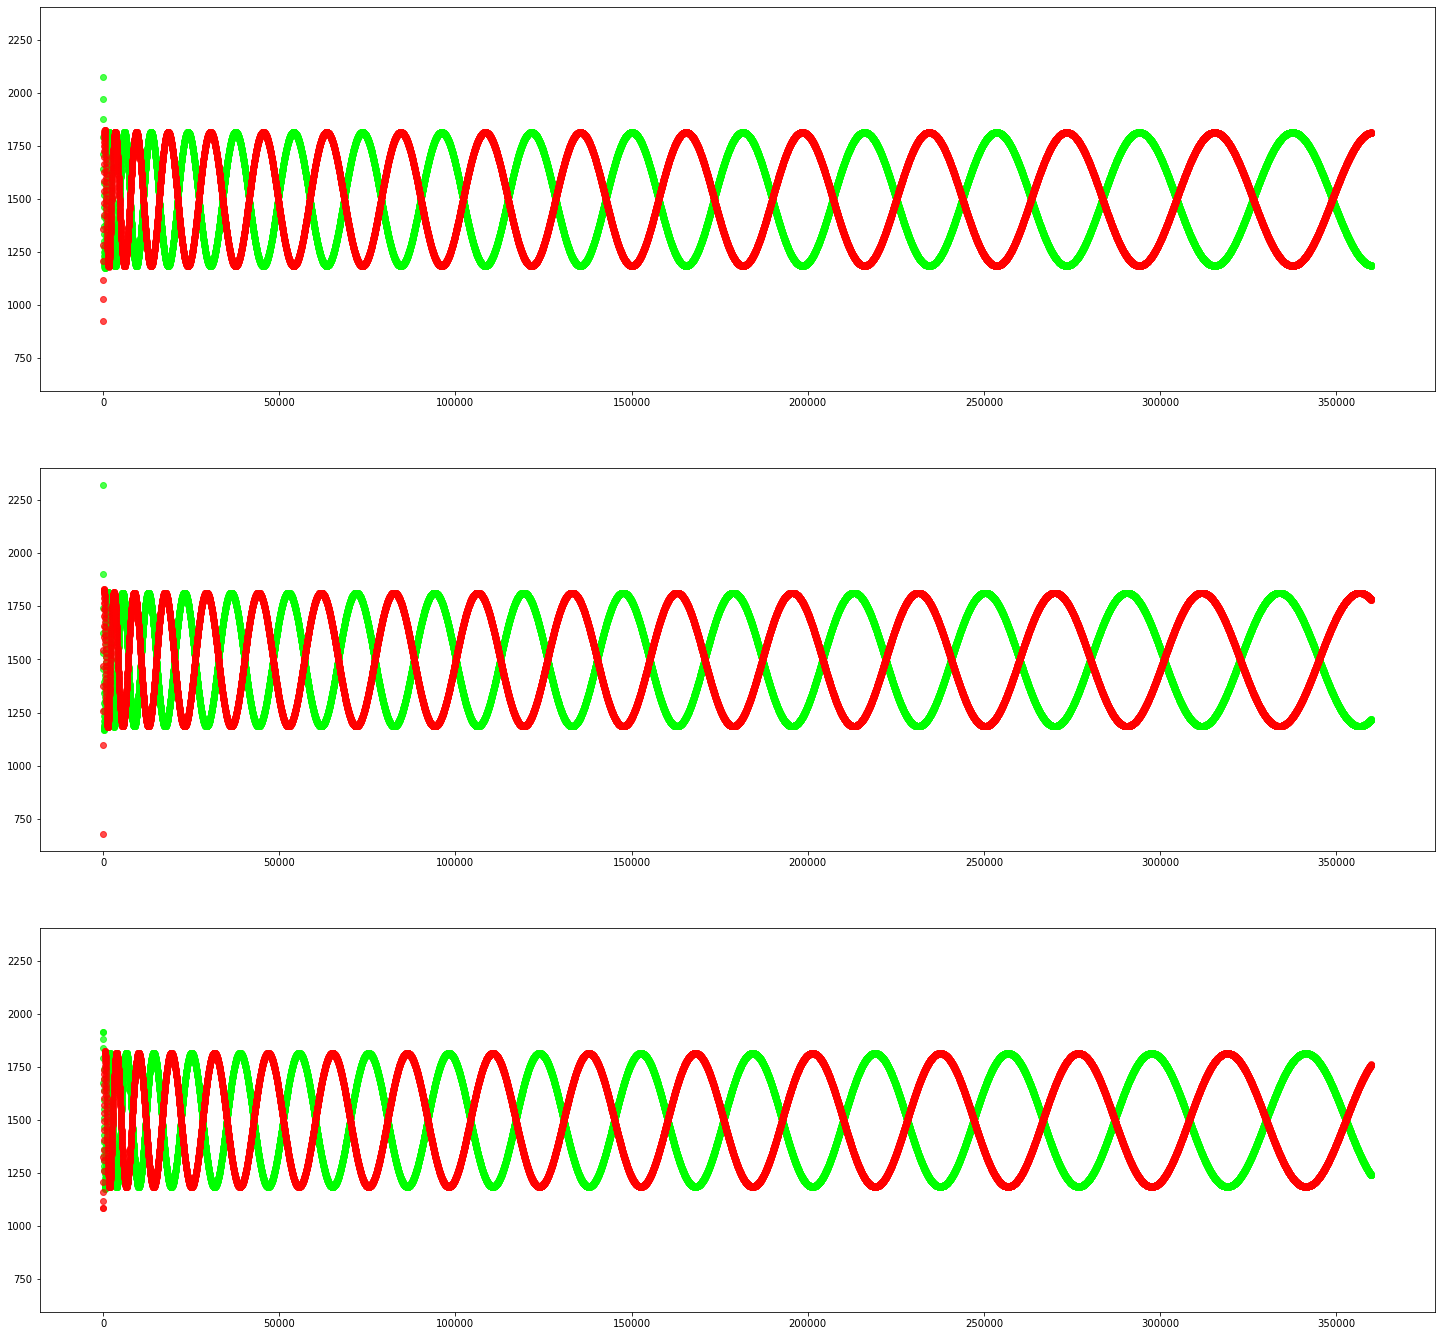

In [8]:
# Calculate velocity to convert to step current
# As with head direction network, small values are boosted, but values that were 0 or less are set back to 0

vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)

vel_x,vel_y = vel_x*I_vel, vel_y*I_vel

# Now we split this across the rings according to their direction of travel

# Axes are:
# Y, as usual
# X_plus_60 (60 degree offset from Y around origin, diagonal bottom-right to upper-left)
# X_plus_120 (120 degree offset from Y around origin, diagonal bottom-left to upper-right)

velocity_magnitude = np.sqrt(vel_x ** 2 + vel_y ** 2)

#if velocity_threshold:

#    velocity_magnitude = velocity_magnitude + minimum_velocity

#    velocity_magnitude[velocity_magnitude < minimum_velocity] = 0.

velocity_angle = np.arctan2(vel_y, vel_x)

# Calculate overall components for use in later analysis

Y_input_total = velocity_magnitude * np.sin(velocity_angle)

Y_plus_60_offset = np.radians(60)
Y_plus_120_offset = np.radians(120)

Y_plus_60_input_total = velocity_magnitude * np.cos(velocity_angle - Y_plus_60_offset)
Y_plus_120_input_total = velocity_magnitude * np.cos(velocity_angle - Y_plus_120_offset)

# Now split into positive and negative to feed to left and right conjunctive cells respectively

positive_magnitude = np.copy(velocity_magnitude)

positive_magnitude[0. > velocity_angle] = 0.

negative_magnitude = np.copy(velocity_magnitude)

negative_magnitude[0. < velocity_angle] = 0.

Y_input_l = positive_magnitude * np.sin(velocity_angle)
Y_input_r = -negative_magnitude * np.sin(velocity_angle)

if tension == True:
    
    #Y_input_l = Y_input_l + 1500
    #Y_input_r = Y_input_r + 1500
    
    
    #Y_input_l = Y_input_l + (Y_input_l - 1500)
    #Y_input_r = Y_input_r + (1500 - Y_input_r)
    
    
    #Y_input_l = minimum_velocity + Y_input_l - Y_input_r
    #Y_input_r = minimum_velocity + Y_input_r - Y_input_l
    
    
    #Y_input_l_boosted = minimum_input + Y_input_l
    #Y_input_r_boosted = minimum_input + Y_input_r
    
    #Y_input_l = Y_input_l_boosted - (Y_input_r_boosted - minimum_input)
    #Y_input_r = Y_input_r_boosted - (Y_input_l_boosted - minimum_input)
    
    
    Y_input_l_boosted = minimum_input + velocity_magnitude + Y_input_l
    Y_input_r_boosted = minimum_input + velocity_magnitude + Y_input_r
    
    Y_input_l = Y_input_l_boosted - (Y_input_r_boosted - minimum_input)# - velocity_magnitude)
    Y_input_r = Y_input_r_boosted - (Y_input_l_boosted - minimum_input)# - velocity_magnitude)
    
# Connect y input to conjunctive layers

#y_l_input = sim.Create('step_current_generator', 1)
#sim.SetStatus(y_l_input,{'amplitude_times': t[1:],'amplitude_values': Y_input_l})

#y_r_input = sim.Create('step_current_generator', 1)
#sim.SetStatus(y_r_input,{'amplitude_times': t[1:],'amplitude_values': Y_input_r})

#sim.Connect(y_l_input,l[0],'all_to_all')
#sim.Connect(y_r_input,r[0],'all_to_all')

Y_plus_60_input_l = positive_magnitude * np.cos(velocity_angle - Y_plus_60_offset)
Y_plus_120_input_l = positive_magnitude * np.cos(velocity_angle - Y_plus_120_offset)

Y_plus_60_input_r = -negative_magnitude * np.cos(velocity_angle - Y_plus_60_offset)
Y_plus_120_input_r = -negative_magnitude * np.cos(velocity_angle - Y_plus_120_offset)

if tension == True:
    
    #Y_plus_60_input_l = Y_plus_60_input_l + 1500
    #Y_plus_120_input_l = Y_plus_120_input_l + 1500
    #Y_plus_60_input_r = Y_plus_60_input_r + 1500
    #Y_plus_120_input_r = Y_plus_120_input_r + 1500
    
    
    #Y_plus_60_input_l = Y_plus_60_input_l + (Y_plus_60_input_l - 1500)
    #Y_plus_60_input_r = Y_plus_60_input_r + (1500 - Y_plus_60_input_r)
    #Y_plus_120_input_l = Y_plus_120_input_l + (Y_plus_120_input_l - 1500)
    #Y_plus_120_input_r = Y_plus_120_input_r + (1500 - Y_plus_120_input_r)
    
    
    #Y_plus_60_input_l = minimum_velocity + Y_plus_60_input_l - Y_plus_60_input_r
    #Y_plus_60_input_r = minimum_velocity + Y_plus_60_input_r - Y_plus_60_input_l
    #Y_plus_120_input_l = minimum_velocity + Y_plus_120_input_l - Y_plus_120_input_r
    #Y_plus_120_input_r = minimum_velocity + Y_plus_120_input_r - Y_plus_120_input_l

    
    Y_plus_60_input_l_boosted = minimum_input + velocity_magnitude + Y_plus_60_input_l
    Y_plus_60_input_r_boosted = minimum_input + velocity_magnitude + Y_plus_60_input_r
    Y_plus_60_input_l = Y_plus_60_input_l_boosted - (Y_plus_60_input_r_boosted - minimum_input)# - velocity_magnitude)
    Y_plus_60_input_r = Y_plus_60_input_r_boosted - (Y_plus_60_input_l_boosted - minimum_input)# - velocity_magnitude)
    
    Y_plus_120_input_l_boosted = minimum_input + velocity_magnitude + Y_plus_120_input_l
    Y_plus_120_input_r_boosted = minimum_input + velocity_magnitude + Y_plus_120_input_r
    Y_plus_120_input_l = Y_plus_120_input_l_boosted - (Y_plus_120_input_r_boosted - minimum_input)# - velocity_magnitude)
    Y_plus_120_input_r = Y_plus_120_input_r_boosted - (Y_plus_120_input_l_boosted - minimum_input)# - velocity_magnitude)

# Connect y_plus_60 input to conjunctive layers

#Y_plus_60_l_input = sim.Create('step_current_generator', 1)
#sim.SetStatus(Y_plus_60_l_input,{'amplitude_times': t[1:],'amplitude_values': Y_plus_60_input_l})
#Y_plus_60_r_input = sim.Create('step_current_generator', 1)
#sim.SetStatus(Y_plus_60_r_input,{'amplitude_times': t[1:],'amplitude_values': Y_plus_60_input_r})

#sim.Connect(Y_plus_60_l_input,l[1],'all_to_all')
#sim.Connect(Y_plus_60_r_input,r[1],'all_to_all')

# Connect y_plus_120 input to conjunctive layers

#Y_plus_120_l_input = sim.Create('step_current_generator', 1)
#sim.SetStatus(Y_plus_120_l_input,{'amplitude_times': t[1:],'amplitude_values': Y_plus_120_input_l})
#Y_plus_120_r_input = sim.Create('step_current_generator', 1)
#sim.SetStatus(Y_plus_120_r_input,{'amplitude_times': t[1:],'amplitude_values': Y_plus_120_input_r})

#sim.Connect(Y_plus_120_l_input,l[2],'all_to_all')
#sim.Connect(Y_plus_120_r_input,r[2],'all_to_all')

print(max(Y_input_l))
print(max(Y_input_r))
print(max(Y_plus_60_input_l))
print(max(Y_plus_60_input_r))
print(max(Y_plus_120_input_l))
print(max(Y_plus_120_input_r))
print(max(velocity_magnitude))
print(len(time))
print(len(Y_input_l))

# Plot velocity components for sanity's sake

fig, axes = plt.subplots(3,1, figsize=(25,24), sharey = True)

axes[0].scatter(time[:-1], Y_input_l, alpha = 0.7, c = 'lime')
axes[0].scatter(time[:-1], Y_input_r, alpha = 0.7, c = 'red')

axes[1].scatter(time[:-1], Y_plus_60_input_l, alpha = 0.7, c = 'lime')
axes[1].scatter(time[:-1], Y_plus_60_input_r, alpha = 0.7, c = 'red')

axes[2].scatter(time[:-1], Y_plus_120_input_l, alpha = 0.7, c = 'lime')
axes[2].scatter(time[:-1], Y_plus_120_input_r, alpha = 0.7, c = 'red')

### Integrate and wrap

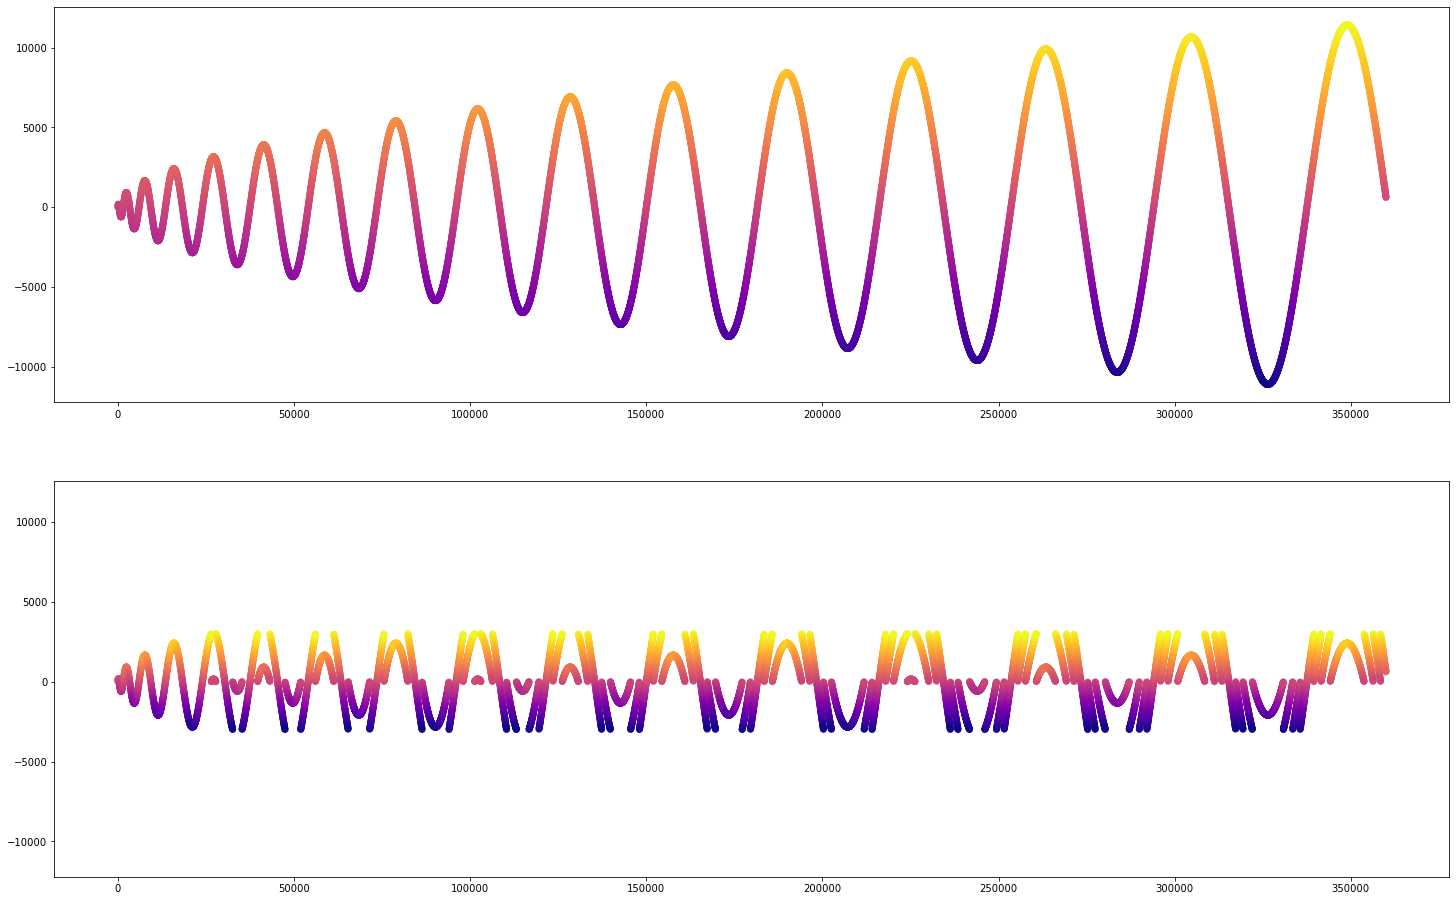

In [9]:
# Unlike the head direction ring, the grid cell axis rings don't represent a particular value of space, simply being a repeating firing pattern that
# due to responding to velocity components, will correlate meaningfully with motion
# However, for the purposes of testing the pyramidal and pa cell firing without ring attractors, a boundary value has to be chosen to represent the
# ring bump wrapping around. Under normal conditions, this value is determined organically by the ring dynamics

boundary = 3000

def wrap_to_distance(distance, boundary):
    
    wrapped = distance
    
    wrapped[distance > 0] = distance[distance > 0] % boundary
    wrapped[distance < 0] = distance[distance < 0] % -boundary
    
    return wrapped

assert boundary % N_pa_cells_per_ring == 0

Y_input_total_distance = scipy.integrate.cumulative_trapezoid(Y_input_total, dx = 0.1, initial = 0)
Y_plus_60_input_total_distance = scipy.integrate.cumulative_trapezoid(Y_plus_60_input_total, dx = 0.1, initial = 0)
Y_plus_120_input_total_distance = scipy.integrate.cumulative_trapezoid(Y_plus_120_input_total, dx = 0.1, initial = 0)

fig, axes = plt.subplots(2,1, figsize=(25,16), sharey = True)

axes[0].scatter(time[1:], Y_input_total_distance, alpha = 0.7, c = Y_input_total_distance, cmap = 'plasma')
#axes[0].scatter(time[1:], Y_plus_60_input_total_distance, alpha = 0.7, c = Y_plus_60_input_total_distance, cmap = 'plasma')
#axes[0].scatter(time[1:], Y_plus_120_input_total_distance, alpha = 0.7, c = Y_plus_120_input_total_distance, cmap = 'plasma')

axes[1].scatter(time[1:], wrap_to_distance(Y_input_total_distance, boundary), alpha = 0.7, c = Y_input_total_distance, cmap = 'plasma')
#axes[1].scatter(time[1:], wrap_to_distance(Y_plus_60_input_total_distance, wrap_distance), alpha = 0.7, c = Y_plus_60_input_total_distance, cmap = 'plasma')
#axes[1].scatter(time[1:], wrap_to_distance(Y_plus_120_input_total_distance, wrap_distance), alpha = 0.7, c = Y_plus_120_input_total_distance, cmap = 'plasma')

### Assign current to pa cells based on 'bump position'

8745
6.0     1765
9.0     1752
3.0     1744
0.0     1642
4.0     1430
7.0     1420
8.0     1403
5.0     1400
10.0    1378
1.0     1358
2.0     1354
11.0    1353
Name: Y_input PA Cell, dtype: int64


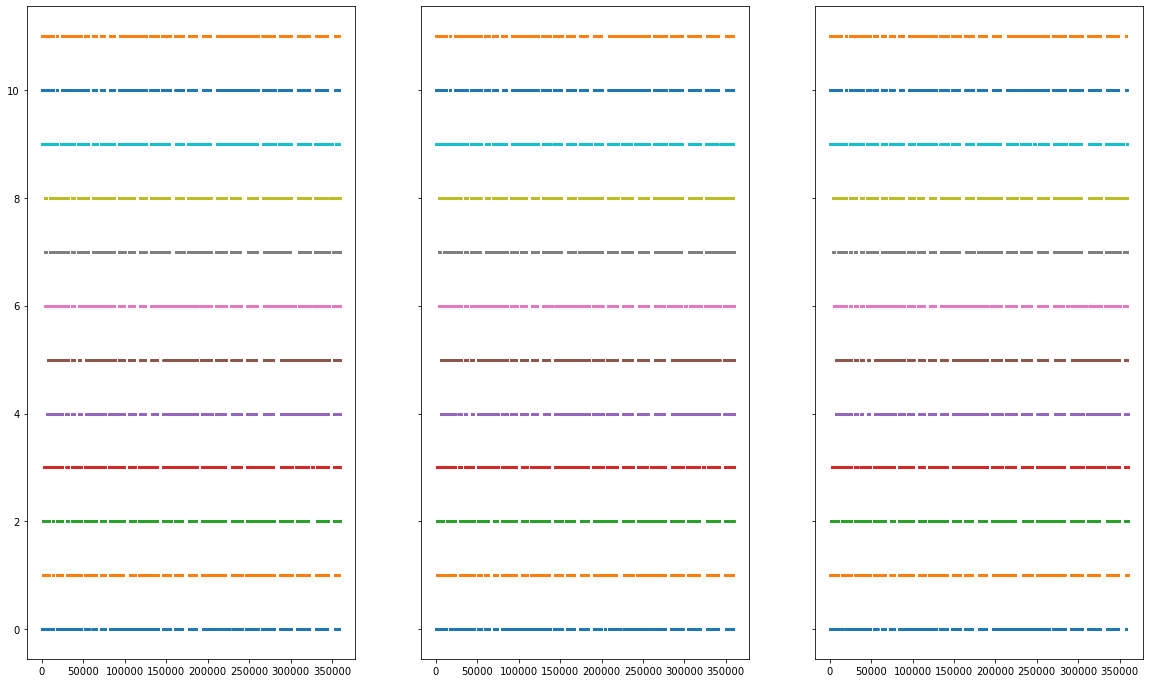

In [10]:
window_size = boundary // N_pa_cells_per_ring

def split_among_pa_cells(distance, window_size, count_pa_cells):
    
    assigned_distance = np.copy(distance)
    
    for i in range(count_pa_cells):
        
        assigned_distance[(i*window_size <= distance) & (distance < (i+1)*window_size)] = i
        
    for i, j in zip(range(count_pa_cells), range(count_pa_cells, 0, -1)):
        
        assigned_distance[((-j)*window_size <= distance) & (distance < (-j+1)*window_size)] = i
        
    return assigned_distance

assigned_distance_Y     = split_among_pa_cells(wrap_to_distance(Y_input_total_distance,          boundary), window_size, N_pa_cells_per_ring)
assigned_distance_Y_60  = split_among_pa_cells(wrap_to_distance(Y_plus_60_input_total_distance,  boundary), window_size, N_pa_cells_per_ring)
assigned_distance_Y_120 = split_among_pa_cells(wrap_to_distance(Y_plus_120_input_total_distance, boundary), window_size, N_pa_cells_per_ring)

assigned_distances      = [assigned_distance_Y, assigned_distance_Y_60, assigned_distance_Y_120]

distances               = [Y_input_total_distance, Y_plus_60_input_total_distance, Y_plus_120_input_total_distance]

print(sum(Y_input_total_distance < 0))

pa_cell_injectors = np.empty(shape = (rings, N_pa_cells_per_ring), dtype = 'int64')

input_signal = pandas.DataFrame({"Time": t[1:], "Y_input": Y_input_total_distance, "Y_input PA Cell": assigned_distance_Y,
                                 "Y_60_input": Y_plus_60_input_total_distance, "Y_60_input PA Cell": assigned_distance_Y_60,
                                 "Y_120_input": Y_plus_120_input_total_distance, "Y_120_input PA Cell": assigned_distance_Y_120})

distance_component_labels = ["Y_input", "Y_60_input", "Y_120_input"]
distance_pa_labels        = ["Y_input PA Cell", "Y_60_input PA Cell", "Y_120_input PA Cell"]

pa_cells = np.concatenate([np.array(pa_cells), np.array(pa_cells)])

print(input_signal["Y_input PA Cell"].value_counts())

for i in range(rings):
    
    pa_cell_injectors[i,:] = sim.Create('step_current_generator', N_pa_cells_per_ring)
    
    #print(pa_cell_injectors[i,:])

fig, ax = plt.subplots(1,rings, figsize = (20, 12), sharex = True, sharey = True)
    
for i, component, pa in zip(range(rings), distance_component_labels, distance_pa_labels):
    
    for j in range(N_pa_cells_per_ring):
        
        #distance_subset = input_signal[input_signal[pa] == j][component].tolist()
        pa_subset = input_signal[input_signal[pa] == j][pa].tolist()
        time_subset = input_signal[input_signal[pa] == j]["Time"].tolist()
        amplitude_sparse = np.where(input_signal[pa] == j, np.repeat(1., len(input_signal["Time"])).tolist(), np.repeat(0., len(input_signal["Time"])).tolist())
        #print(len(time_subset))
        #print(len(distance_subset))
        #print(j)
        #print(sum(input_signal[pa] == j))
        #ax.hist(input_signal[input_signal[pa] == j]["Time"])
        #print(input_signal[input_signal[pa] == j][component].value_counts())
        ax[i].scatter(time_subset, pa_subset, s = 4)
        
        #sim.SetStatus([pa_cell_injectors[i][j]],{'amplitude_times': t[np.argwhere(distances[i][assigned_pa_cells[i] == j])].squeeze().tolist(),'amplitude_values': distances[i][assigned_pa_cells[i] == j].squeeze().tolist()[1:]})
        #sim.SetStatus([pa_cell_injectors[i][j]],{'amplitude_times': t[1:],'amplitude_values': distances[i]})
        #sim.SetStatus([pa_cell_injectors[i][j]],{'amplitude_times': time_subset,'amplitude_values': np.repeat(1., len(time_sparse)).tolist()})
        sim.SetStatus([pa_cell_injectors[i][j]],{'amplitude_times': input_signal["Time"].tolist(),'amplitude_values': amplitude_sparse})
        
        sim.Connect([pa_cell_injectors[i][j]], [pa_cells[i][j]],'all_to_all',syn_spec={'weight': w_ex_pa, 'delay': delay})
        
        #print(pa_cells[i][j])

### Bump-forming current generator

## Run simulation, or load prior run

In [11]:
if simulate_or_load == 'simulate':

    # Set timer to measure runtime, then start the simulation

    tic = tm.time()
    sim.Simulate(sim_len)
    print(f'Simulation run time: {np.around(tm.time()-tic,2)} s  Simulated time: {np.around(sim_len/1000,2)} s')
    
    #np.save(f"excitatory_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", np.array([sim.GetStatus(exc_spikes[0]),
    #                                                                           sim.GetStatus(exc_spikes[1]),
    #                                                                           sim.GetStatus(exc_spikes[2])]))
    np.save(f"pa_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", np.array([sim.GetStatus(pa_spikes[0]),
                                                                       sim.GetStatus(pa_spikes[1]),
                                                                       sim.GetStatus(pa_spikes[2])]))
    np.save(f"pyramidal_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", sim.GetStatus(pyramidal_spikes))
    
elif simulate_or_load == 'load':
    
    #exc_spikes = np.load(f"excitatory_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", allow_pickle = True)
    pa_spikes = np.load(f"pa_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", allow_pickle = True)
    pyramidal_spikes = np.load(f"pyramidal_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", allow_pickle = True)
    
else:
    
    raise ValueError

Simulation run time: 90.07 s  Simulated time: 360.0 s

Oct 06 16:03:17 NodeManager::prepare_nodes [Info]: 
    Preparing 280 nodes for simulation.

Oct 06 16:03:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 280
    Simulation time (ms): 360000
    Not using OpenMP
    Not using MPI

Oct 06 16:04:47 SimulationManager::run [Info]: 
    Simulation finished.


## Visualise spikes from run

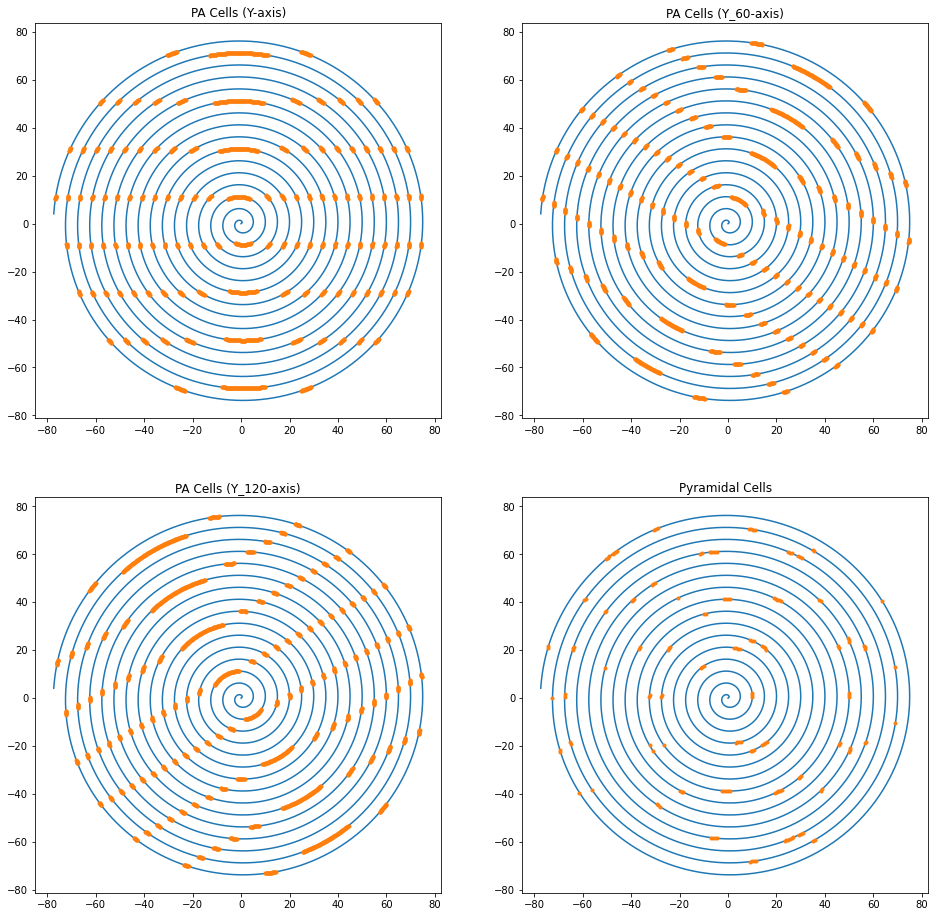

In [12]:
# View pyramidal cell firing

from collections import Counter

if spiral_or_rat == 'spiral':

    t = np.arange(0,sim_len,dt)*1.
    time = [i * 1. for i in t if i < sim_len]

elif spiral_or_rat == 'rat':
    
    t = rat_dataset['post'].squeeze()
    t = t * 1000
    
    time = t

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pa_spikes[0])[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pa_spikes[0][0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
occurence_count = Counter(sp)
cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,16),facecolor='w')
ax1.set_title("PA Cells (Y-axis)")
ax1.plot(pos_x,pos_y)
ax1.plot(xs,ys,'.')

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pa_spikes[1])[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pa_spikes[0][0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
occurence_count = Counter(sp)
cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax2.set_title("PA Cells (Y_60-axis)")
ax2.plot(pos_x,pos_y)
ax2.plot(xs,ys,'.')

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pa_spikes[2])[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pa_spikes[0][0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
occurence_count = Counter(sp)
cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax3.set_title("PA Cells (Y_120-axis)")
ax3.plot(pos_x,pos_y)
ax3.plot(xs,ys,'.')

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pyramidal_spikes)[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pyramidal_spikes[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
occurence_count = Counter(sp)
cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax4.set_title("Pyramidal Cells")
ax4.plot(pos_x,pos_y)
ax4.plot(xs,ys,'.')

8.051893154047753e-05


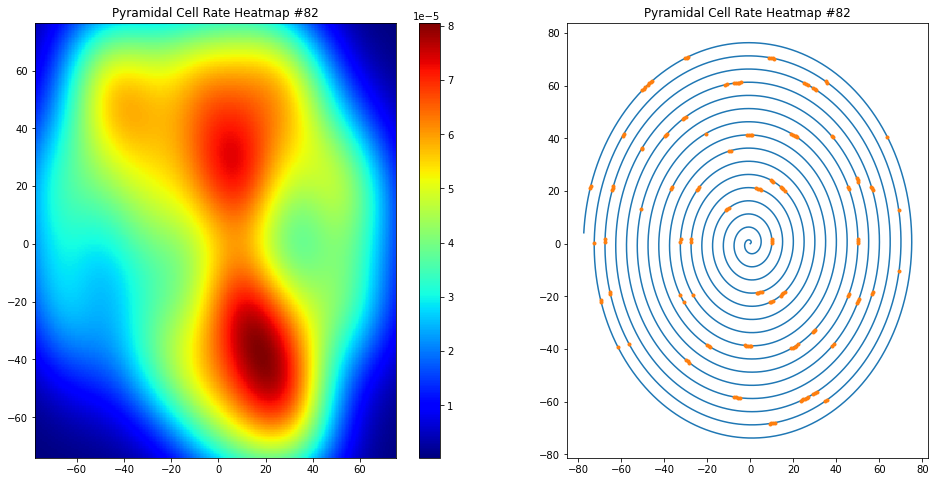

In [13]:
# Convert to heatmaps

from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.stats import gaussian_kde
from scipy.signal import correlate2d

mean_filter = False
mean_filter_window = 15 # 15 for Sargolini paper
bin_size_cm = 0.3 # 3x3cm bins for Sargolini paper
    
cell = cell
fig, ax = plt.subplots(1,2, figsize = (16, 8), gridspec_kw={'width_ratios': [1.25, 1]})
hist = ax[0]
original = ax[1]

spktms1 = t[sp==cell]
spktms1 = (spktms1//20)*20
spktms1=spktms1[1:]

xs = np.empty((len(spktms1)))
ys = np.empty((len(spktms1)))
    
#non_zero_vel_time = time[1:]
#non_zero_vel_time = non_zero_vel_time[velocity_magnitude > 1]
        
#xs = pos_x[np.where(np.isin(non_zero_vel_time, spktms1))]
#ys = pos_y[np.where(np.isin(non_zero_vel_time, spktms1))]

xs = pos_x[np.where(np.isin(time[1:], spktms1))]
ys = pos_y[np.where(np.isin(time[1:], spktms1))]

nbins=max([*pos_x, *pos_y]) // bin_size_cm
    
if mean_filter:
    
    #(pos_x, pos_y) = uniform_filter([pos_x, pos_y], size = mean_filter_window)
    (xs, ys) = uniform_filter([xs, ys], size = mean_filter_window)
    
    k = gaussian_kde([xs,ys])
    xi, yi = np.mgrid[min(pos_x):max(pos_x):nbins*1j, min(pos_y):max(pos_y):nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
else:
    
    k = gaussian_kde([xs,ys])
    xi, yi = np.mgrid[min(pos_x):max(pos_x):nbins*1j, min(pos_y):max(pos_y):nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
print(max(zi))

hist.set_title("Pyramidal Cell Rate Heatmap #{}".format(cell))
#plot.plot(pos_x[:len(time)],pos_y[:len(time)])
#hist.hist2d(xs,ys,density=True, range = [[min(pos_x),max(pos_x)],[min(pos_y),max(pos_y)]])
colourplot = hist.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = 'jet')
#colourplot = correlate2d(colourplot, colourplot)
plt.colorbar(colourplot, ax = hist)


original.set_title("Pyramidal Cell Rate Heatmap #{}".format(cell))
original.plot(pos_x[:len(time)],pos_y[:len(time)])
original.plot(xs, ys, '.')

(array([{'senders': array([1, 1, 1, ..., 3, 3, 3]), 'times': array([2.300000e+01, 2.790000e+01, 3.280000e+01, ..., 3.599863e+05,
              3.599912e+05, 3.599961e+05])}                                                                                    ],
      dtype=object), array([1]))
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([6723, 5563, 5547, 7139, 5854, 5732, 7224, 5816, 5746, 7172, 5644,
       5543]))
(array([{'senders': array([13, 13, 13, ..., 15, 15, 15]), 'times': array([2.300000e+01, 2.790000e+01, 3.280000e+01, ..., 3.599875e+05,
              3.599924e+05, 3.599973e+05])}                                                                                          ],
      dtype=object), array([1]))
(array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), array([6241, 5825, 5835, 6523, 6178, 6018, 6644, 6119, 6064, 6564, 5883,
       5815]))
(array([{'senders': array([25, 25, 25, ..., 26, 26, 26]), 'times': array([2.300000e+01, 2.790000e+01, 3.280000e+

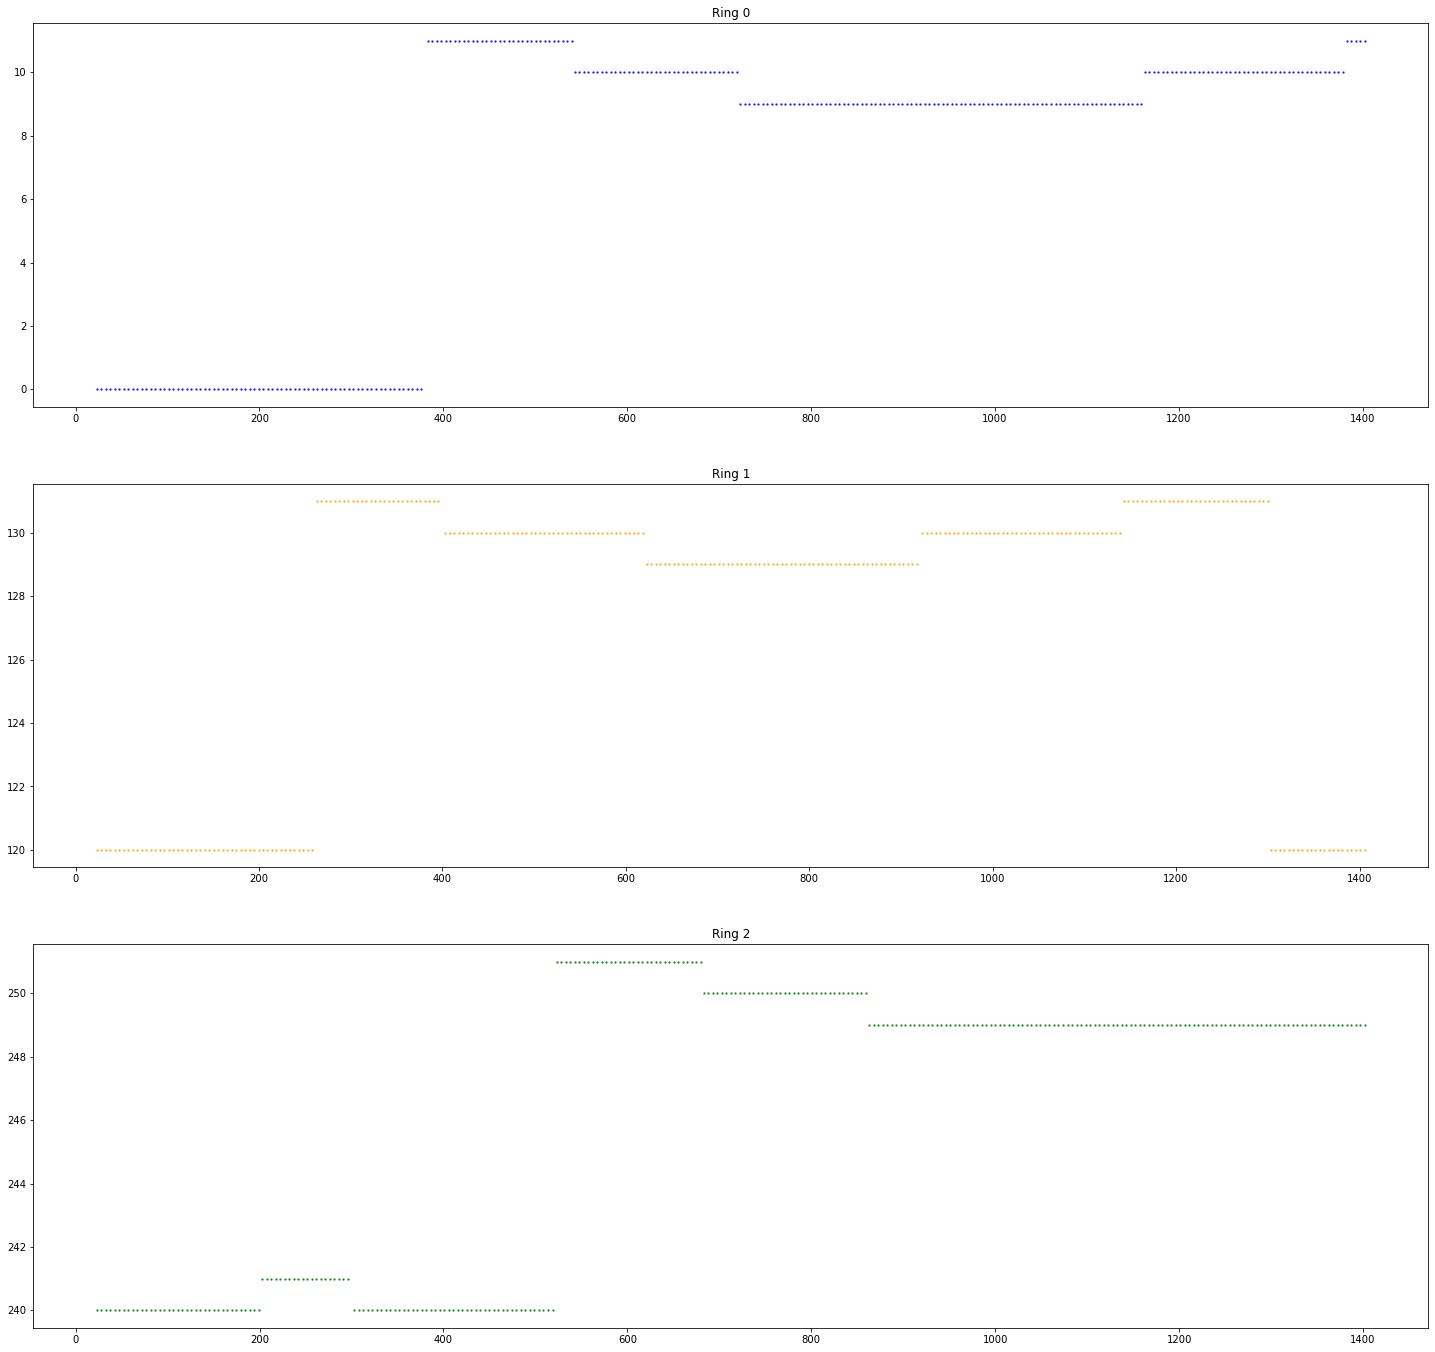

In [14]:
# Plot PA cell activity

fig, axes = plt.subplots(3,1, figsize=(25,24))

time_start = 0
time_end = sim_len // 256

colours = ['blue', 'orange', 'green']

offsets = [0, np.radians(60), np.radians(-60)]

time = np.array(time)
time = time[time < time_end]

velocity_components = [Y_input_total[:len(time)], Y_plus_60_input_total[:len(time)], Y_plus_120_input_total[:len(time)]]
specific_velocity_components = [[Y_input_l[:len(time)], Y_input_r[:len(time)]], [Y_plus_60_input_l[:len(time)],
                                Y_plus_60_input_r[:len(time)]], [Y_plus_120_input_l[:len(time)], Y_plus_120_input_r[:len(time)]]]

for i, colour, axis, offset, velocity_component, specific_velocity_component in zip(range(len(axes)), colours, axes, offsets, velocity_components, specific_velocity_components):
    
    if simulate_or_load == 'simulate':

        ev = sim.GetStatus(pa_spikes[i])[0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    elif simulate_or_load == 'load':

        ev = pa_spikes[i][0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    else:

        raise ValueError
        
    print(np.unique(ev, return_counts=True))
    print(np.unique(sp, return_counts=True))
    
    neuron_index = sp - np.min(sp)
    
    t = t[t < time_end]
    neuron_index = neuron_index[:len(t)] + i * N_ex
    
    #ax_twin = axis.twinx()
    
    #positive_component = velocity_component[velocity_component > 0]
    #if tension:
        #positive_component = positive_component + (positive_component - 1500)
    #positive_time = time[velocity_component > 0]
    
    #negative_component = velocity_component[velocity_component < 0]
    #if tension:
        #negative_component = negative_component - (1500 - negative_component)
    #negative_time = time[velocity_component < 0]
    
    #stationary_component = velocity_component[np.abs(velocity_component) < 2]
    #stationary_time = time[np.abs(velocity_component) < 2]
    
    #positive_component = velocity_component[velocity_component > 0]
    #positive_time = time[velocity_component > 0]
    #negative_component = velocity_component[velocity_component < 0]
    #negative_time = time[velocity_component < 0]
    
    positive_component = np.copy(velocity_component)
    positive_component[positive_component < 0.] = 0.
    negative_component = np.copy(velocity_component)
    negative_component[negative_component > 0.] = 0.
    positive_time = time#[velocity_component]
    negative_time = time#[velocity_component]
    if tension:
        #positive_component = minimum_input + positive_component - 0
        #negative_component = - minimum_input + negative_component + 0
        
        positive_component_boosted = minimum_input + positive_component
        negative_component_boosted = minimum_input + negative_component

        positive_component = positive_component_boosted - (negative_component_boosted - minimum_input)
        negative_component = negative_component_boosted - (positive_component_boosted - minimum_input)
    
    axis.scatter(t, neuron_index, alpha = 0.7, c = colour, s = 2)
    #ax_twin.scatter(time[20:], velocity_component[20:], c = 'black')
    #ax_twin.scatter(positive_time[20:], positive_component[20:], alpha = 0.7, c = 'lime')
    #ax_twin.scatter(negative_time[20:], negative_component[20:], alpha = 0.7, c = 'red')
    #ax_twin.scatter(stationary_time[20:], stationary_component[20:], alpha = 0.7, c = 'purple')
    
    axis.set_title(f"Ring {i}")

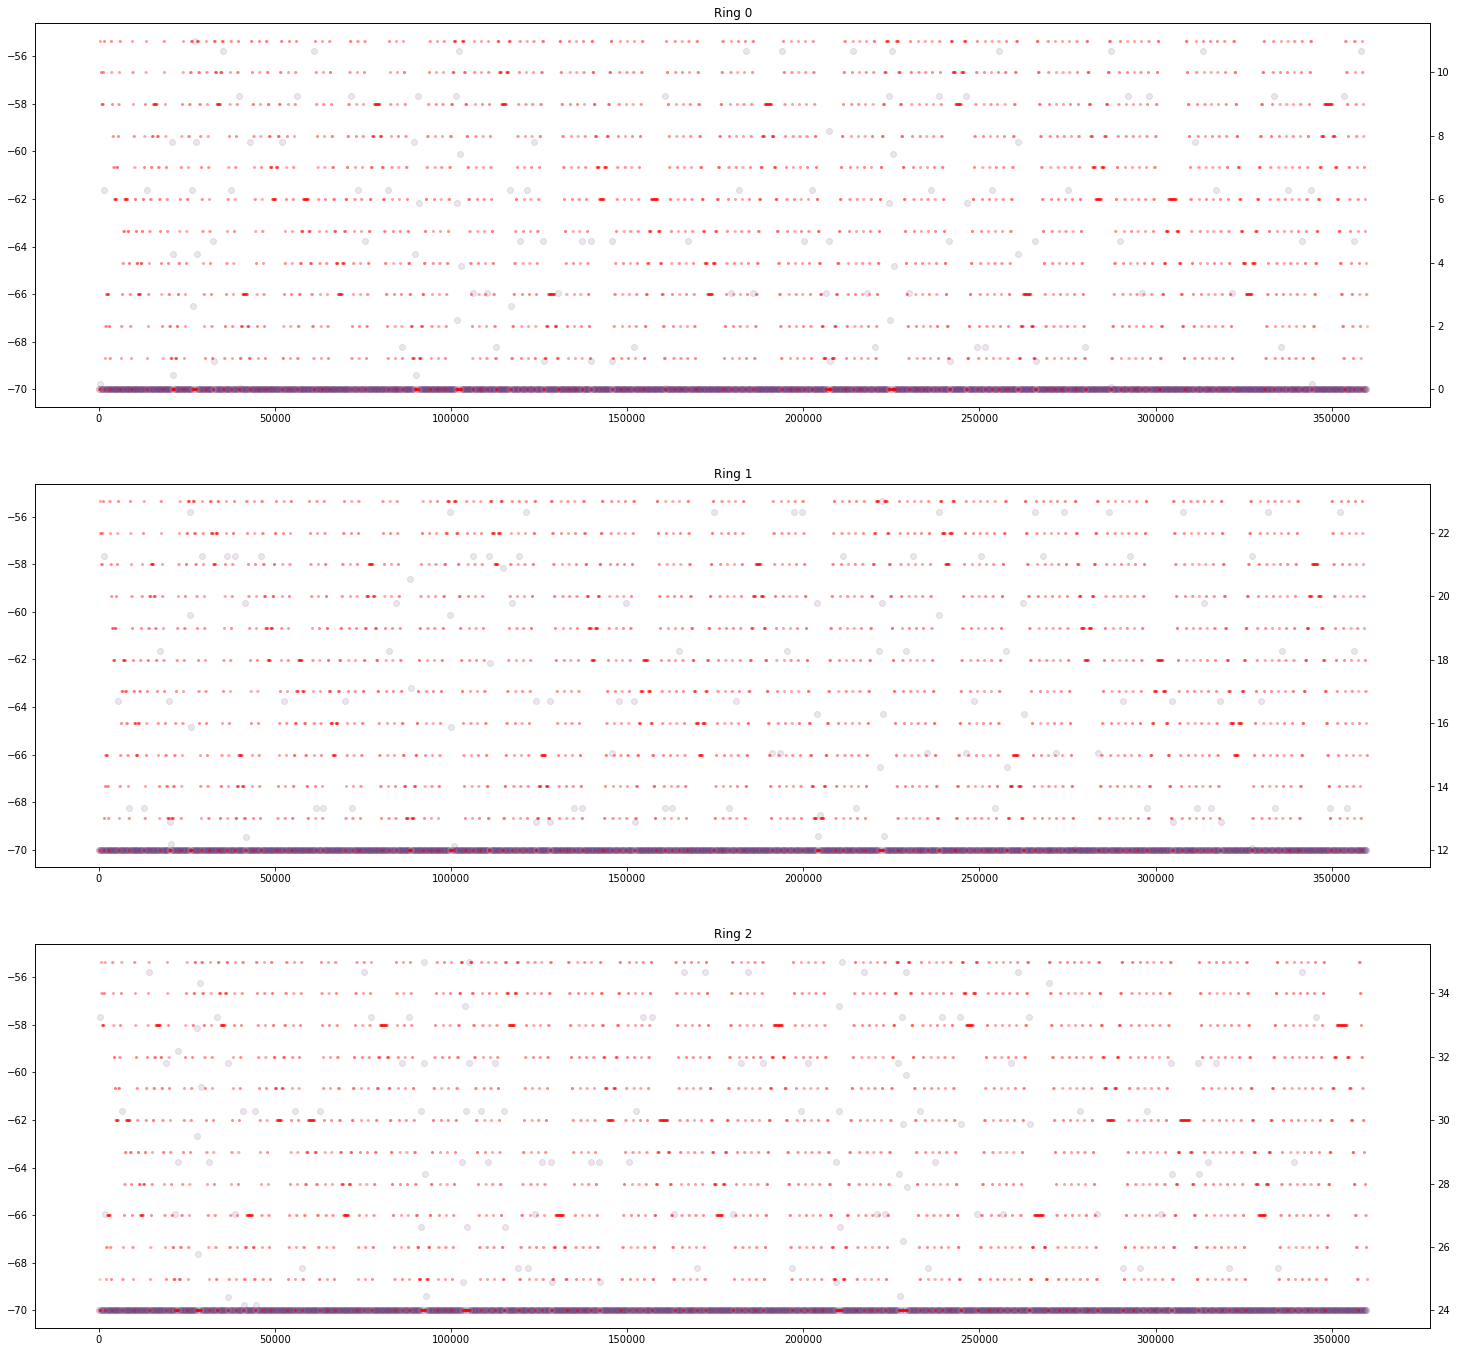

In [15]:
# Plot PA activity with membrane voltage.
# Note that the iaf_psc_alpha model only models sub-threshold dynamics, so the apparent membrane potential will never go above firing threshold
# Despite this, it will still generate spikes

if simulate_or_load == 'simulate':

    from matplotlib import cm

    fig, axes = plt.subplots(3,1, figsize=(25,24))

    time_start = 0
    time_end = sim_len // 8

    colour_index = np.linspace(0, 1, num = 120)
    colours = cm.get_cmap('viridis')(colour_index)

    for i, pa_colour, axis, offset, pa_ring in zip(range(len(axes)), colours, axes, offsets, pa_cells):

        ev = sim.GetStatus(pa_voltage[i])[0]['events']
        t = ev['times']
        sp = ev['senders']
        voltage = ev['V_m']

        pa_index = pa_ring[0]

        target_neuron_indexes = np.argwhere(sp == pa_index)

        target_neuron_times = t[target_neuron_indexes][::10]

        target_neuron_voltages = voltage[target_neuron_indexes][::10]

        axis.scatter(target_neuron_times, target_neuron_voltages, alpha = 0.1, color = pa_colour)

        ev = sim.GetStatus(pa_spikes[i])[0]['events']
        t = ev['times']
        sp = ev['senders']

        ax_twin = axis.twinx()

        neuron_index = sp - np.min(sp)

        neuron_index = neuron_index + i * N_pa_cells_per_ring

        ax_twin.scatter(t[::10], neuron_index[::10], alpha = 0.1, c = 'red', s = 4)

        axis.set_title(f"Ring {i}")